# Working with Shapefiles and OSM Part I

**Author**: [Erika Fille Legara](www.erikalegara.net)

You are free to use (or change) this notebook for any purpose you'd like. However, please respect the [MIT License](https://github.com/eflegara/PythonMaps/blob/master/LICENSE)  that governs its use, and for copying permission.

Copyright © 2016 Erika Fille Legara


---
## Description
This recipe is the first of a series of Python notebooks on shapefiles and OSM files that I am working on. The datasets utilized come from two different sources. The first source is the GADM database of Global Administrative Areas, which provides the shapes (outline) of a country's administrative regions. The second source is OpenStreetMap (Part II), which provides similar information on the same administrative regions ++ (roads, buildings, waterways, coasts, etc.). Essentially, OSM provides more details. 

I usually perform map drawings (cartography) using [R]. Truth be told, I find [R] more intuitive when it comes to creating maps ([choropleths](https://en.wikipedia.org/wiki/Choropleth_map)). However, as a pythonista, I think I *have* to know how to read, manipulate, and draw maps in Python. Here, I document the "learning" process. 

---
## Let's Dig In
First things first, import the necessary packages. The `Basemap` package is used for drawing and plotting maps (and also for reading shapefiles). The `shapefile` package provides read and write support for the ESRI Shapefile format.  

In [1]:
try:
    from mpl_toolkits.basemap import Basemap
    import shapefile

    import os.path
    import matplotlib.pyplot as plt
    import urllib
    %matplotlib inline
except:
    import traceback
    traceback.print_exc()
    raise ImportError('Something failed, see above.')

---
## Loading the Shapefiles
Here, we load the shapefiles for the Philippines that I have pre-downloaded from [GADM](http://www.gadm.org/). For the Philippines, the GADM website provides four different administrative levels: country, provincial, city, and barangay levels. I was really surprised (**happily** surprised) that they even have the boundaries down to the barangay level. *Good job, Internet and open data!*

We read all files and store them in the variables `phl0`, `phl1`, `phl2`, and `phl3`.

In [2]:
phl0 = shapefile.Reader("PHL_adm_shp/PHL_adm0")
phl1 = shapefile.Reader("PHL_adm_shp/PHL_adm1") 
phl2 = shapefile.Reader("PHL_adm_shp/PHL_adm2")
phl3 = shapefile.Reader("PHL_adm_shp/PHL_adm3")

Let's have a look at the maps these shapefiles generate. And visualize what we mean by "different administrative region levels".

In [3]:
m = Basemap(llcrnrlon=115,llcrnrlat=3.5,urcrnrlon=129,urcrnrlat=22,
            resolution='i', projection='tmerc', lat_0 = 14, lon_0 = 120)

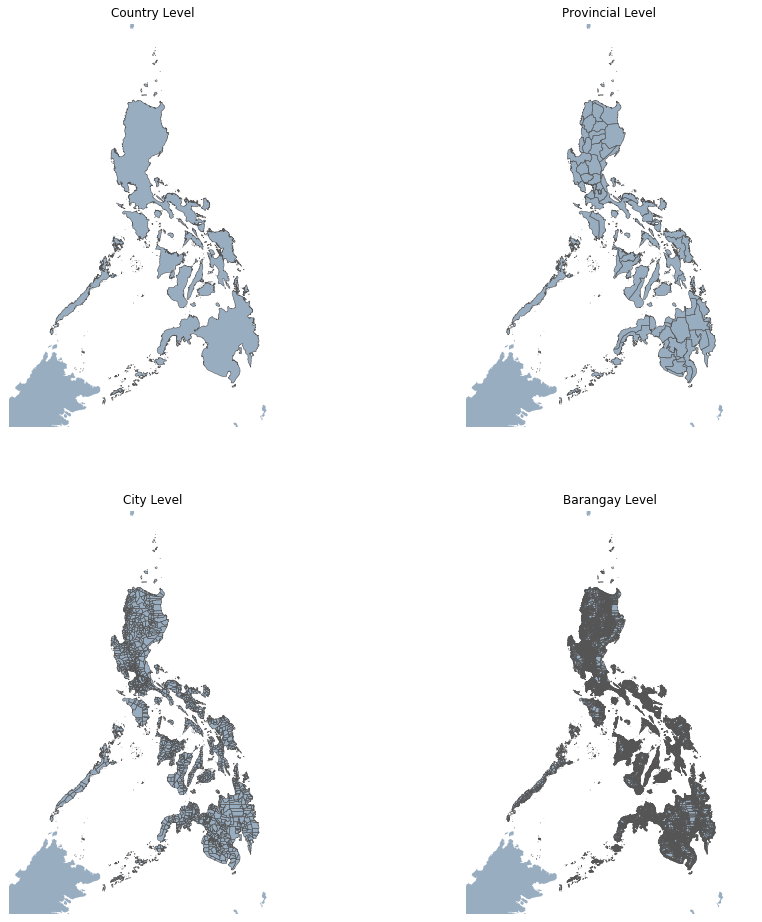

In [4]:
fig = plt.figure(figsize=(15,16), frameon=False)

ax1 = fig.add_subplot(2, 2, 1)
m.readshapefile('./PHL_adm_shp/PHL_adm0','PHL_adm0', color="#555555", zorder=2)
m.drawmapboundary(color='white', linewidth=3)
m.fillcontinents(lake_color='none', color="#003366", alpha=.4)
ax1.set_title("Country Level")

ax2 = fig.add_subplot(2, 2, 2)
m.readshapefile('./PHL_adm_shp/PHL_adm1','PHL_adm1', color="#555555", zorder=2)
m.drawmapboundary(color='white', linewidth=3)
m.fillcontinents(lake_color='none', color="#003366", alpha=.4)
ax2.set_title("Provincial Level")

ax3 = fig.add_subplot(2, 2, 3)
m.readshapefile('./PHL_adm_shp/PHL_adm2','PHL_adm2', color="#555555", zorder=2)
m.drawmapboundary(color='white', linewidth=3)
m.fillcontinents(lake_color='none', color="#003366", alpha=.4)
ax3.set_title("City Level")

ax4 = fig.add_subplot(2, 2, 4)
m.readshapefile('./PHL_adm_shp/PHL_adm3','PHL_adm3', color="#555555", zorder=2)
m.drawmapboundary(color='white', linewidth=3)
m.fillcontinents(lake_color='none', color="#003366", alpha=.4)
ax4.set_title("Barangay Level")

plt.show()

What we want to do next is to identify the polygons in these maps. Note that each polygon represents a province, a city, or a barangay, depending on the administrative level. Of course, for the country level, there's only one "polygon" or shape, which is the shape of the entire country.

Note that shapefiles are NOT image files; they are "text" files where each geometry (province, city, or barangay) is provided with a name, an ID, lat/lon information, among others. Shapefiles usually provide us with two types of information: **fields** and **shapes**. The best way to understand these is to check what is inside the shapefiles. Let's dissect both separately below.

---
## Fields
The **fields** essentially contain certain descriptive "attributes" of a shape. To illustrate, let us use and focus on the shapefile stored in the variable `phl1`. Remember, this particular shapefile provides us with the Philippine provinces.

To check the fields, we execute `phl1.fields` below and store it in the variable `fields`.

In [5]:
fields = phl1.fields
print fields
print "\nNumber of fields: ", len(fields)

[('DeletionFlag', 'C', 1, 0), ['ID_0', 'N', 10, 0], ['ISO', 'C', 3, 0], ['NAME_0', 'C', 75, 0], ['ID_1', 'N', 10, 0], ['NAME_1', 'C', 75, 0], ['HASC_1', 'C', 15, 0], ['CCN_1', 'N', 10, 0], ['CCA_1', 'C', 254, 0], ['TYPE_1', 'C', 50, 0], ['ENGTYPE_1', 'C', 50, 0], ['NL_NAME_1', 'C', 50, 0], ['VARNAME_1', 'C', 150, 0]]

Number of fields:  13


What this tells us is that, if we exclude the "DeletionFlag" tuple, there are 12 fields (*or columns if you think MSExcel*) in the shapefile: "ID_0", "ISO", "NAME_0", "ID_1", "NAME_1", "HASC_1", "CCN_1", "CCA_1", "TYPE_1", "ENGTYPE_1", "NL_NAME_1", "VARNAME_1". For each province (or polygon) in the shapefile, these fields are filled with descriptive information. 

Let's have a look at the sample entries (or records).

### Records
Looking at the **records** or entries, we expect to see a list of provinces (of course).

In [6]:
records = phl1.records()
print type(records), len(records)

<type 'list'> 81


The shapefile has 81 entries (these are just the 81 provinces). 

To access each record, just index them as you would a typical Python `list`. Each element in this list provides details as listed in the `fields` variable above. That is, the first element is the `ID_0` which is the country ID. This is followed by the `ISO` field, which is the country code (three digit); then you have `NAME_0`, which is the name of the country. The field `NAME_1` is the 5th element (index 4, since Python starts counting at 0) in the list; and that is the name of the province.

Let us take a look at the first entry in the **records** list. Again, in Python, the first element has the index 0.

In [7]:
sample_entry = records[0]
print sample_entry

[179, 'PHL', 'Philippines', 1, 'Abra', 'PH.AB', 0, '1401', 'Lalawigan|Probinsya', 'Province', '                                                  ', '                                                                                                                                                      ']


The first entry is the Philippine Province *Abra*. To get the list of all provinces, just iterate through the list of `records`. In the code snippet below, we list the first 5 provinces in the list. We will just print out their names and leave out other details. The name field is the 5th element in the `fields` list.

In [8]:
for entry in records[0:5]:
    print entry[4] # field `NAME_1`

Abra
Agusan del Norte
Agusan del Sur
Aklan
Albay


---
## Geometries 
As mentioned, shapefiles provide us with two types of information: fields and shapes. In this section, we learn more about the shapes (or geometry) of these entries (each province). 

What are the bounding boxes of the shapes, on which points (lat, lon) do the provincial boundary lie, etc.? 

To extract this information, we just call the `shapes()` function. Again, as expected, there are 81 shapes for the shapefile `PHL_adm1`.

In [9]:
shapes = phl1.shapes()
len(shapes)

81

In [10]:
type(shapes)

list

What is inside each entry of the `shapes` list? We use the built-in `dir()` function to look at the _attributes_ of each entry in the `shapes` list.

In [11]:
print dir(shapes[0])

['__doc__', '__geo_interface__', '__init__', '__module__', 'bbox', 'parts', 'points', 'shapeType']


We are particularly interested in the the 5th attribute called `bbox`. As the name suggests, this will give us the bounding box of the provinces in the shapefile `PHL_adm1`. And, if we use `PHL_adm2`, it will give us the city boundaries; then barangay if we use `PHL_adm3`.

Below, let's look at the bounding box of the first province in the list.

In [12]:
bbox = shapes[0].bbox
print bbox

[120.46719360351585, 17.15698051452648, 121.12270355224611, 17.978069305420057]


---
## Fields (Records) + Geometries
Remember, the **records** (fields) contain the name details (attribute information) of the entries while the **shapes** contain the geometric information of each entry. Now, let's combine the fields/records and the shapes (geometry) together. For this, we can use the `shapeRecords()` function. 

Again, let us call the `dir()` function to look at the attribtues of each of the `shapeRecord` entry.

In [13]:
shapeRecs = phl1.shapeRecords()
print dir(shapeRecs[0])

['__doc__', '__init__', '__module__', 'record', 'shape']


Looks pretty straightforward. Two things: record and shape. Clearly, the `record` attribute is for the "records" and the `shape` is for the geometry. Remember from above that `record` has the following attributes: ID number, country, provincial name, etc.; `shape`, on the other hand, has `bbox`, `parts`, `points`, and `shapeType`.

I am interested in both the **name** and the **bounding box** of all provinces, and I want to store them in a [Python dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) that I will call `prov_bbox` for later use.

In [14]:
prov_bbox = {}

In [15]:
for entry in shapeRecs:
    ### The fifth element (index 4) in the record fields
    ### gives the name of the entry (province).
    prov_bbox[entry.record[4]] = entry.shape.bbox

What we have is a Python dictionary of provincial names (key) and the corresponding bounding boxes (value). 

Let's list the first five items in the dictionary `prov_bbox`.

In [16]:
prov_bbox.items()[0:5]

[('Batanes',
  [121.7777786254884, 20.260000228881893, 122.03598022460953, 21.070140838623054]),
 ('Isabela',
  [121.33065032959007, 16.389820098877067, 122.52889251708994, 17.54814910888674]),
 ('Camarines Norte',
  [122.29929351806675, 13.837129592895621, 123.1174468994144, 14.500610351562578]),
 ('Biliran',
  [124.25421142578148, 11.46261978149414, 124.61961364746095, 11.816769599914664]),
 ('Sultan Kudarat',
  [124.01526641845749, 6.113609790802116, 125.19692993164087, 6.883399963378928])]

Why do I need this information? I will use it to automate the download of [OSM files](http://www.openstreetmap.org/about), which I will cover in the second part of the series. Below is a teaser of what we'll be able to plot after the second part of the series. 

Cheers!

!["Maps of some of the cities of the Philippines"](./img/maps.png "Metropolitan Manila cities")